# <b>Module 3 - Downstream Analysis and Visualization</b>
--------------------------------------------

## Overview
In this module, we will explore downstream analyses and visualization techniques for MeRIP-seq data, focusing on differential methylation and gene expression data. This includes interpreting methylation patterns, functional enrichment, and integrating RNA methylation with gene expression to gain insights into condition-specific changes in samples from different conditions. The module will cover essential steps such as package installation, data preparation, meta-gene and volcano plot generation, functional enrichment analysis, and RNA methylation and gene expression integration.

<img src="images/submodule-3.png" width="600" />

- **Kernel**: R
- **Input**: .bed files (differential peaks), .txt (or .tsv/.csv, gene count table from input samples)
- **Output**: plots, functional analysis results


## Learning Objectives
+ **Learning Objective 1**: Understand the processes of downstream analysis and visualization for MeRIP-seq data, including differential methylation and gene expression analysis.
+ **Learning Objective 2**: Develop practical skills in generating key visualizations:
    - **2.1**: Create volcano plots to visualize significant differential methylation and gene expression changes.
    - **2.2**: Generate meta-gene plots to illustrate methylation distribution across gene features.
+ **Learning Objective 3**: Perform functional enrichment analysis to interpret the biological significance of differentially methylated or expressed genes.
+ **Learning Objective 4**: Integrate differential RNA methylation and gene expression data to identify genes with both methylation and expression changes, and visualize these relationships.


## Prerequisites
All the data needed in this submodule will be downloaded from cloud storage (AWS S3) or directly from online resources. 

## Outline
1. **Getting started**
     - Install packages
     - Set up environment, establishing input and output directories.
     - Download data files.
2. **RNA methylation data exploration and visualization**
    - Volcano plot
    - Meta-Gene plot
3. **Functional enrichment analysis**
    - Gene Ontology (GO) Enrichment Analysis
    - KEGG pathway Enrichment analysis
4. **Integration of RNA Methylation and Gene Expression** 
    - Extract gene expression data from Input samples
    - Differential gene expression analysis (DESeq2)
    - Integrate gene expression and RNA methylation
    

----
## <b>1. Get Started</b>


### 1.1 Install packages <mark style="background-color:AntiqueWhite;">(⏰ ~40 minites)</mark>

In [1]:
system("conda install -n R -c conda-forge r-r.utils r-vcfr")
system("conda install -n R -c bioconda bioconductor-enhancedvolcano bioconductor-clusterprofiler bioconductor-org.hs.eg.db")
system("conda install -n R -c bioconda bioconductor-rsamtools bioconductor-genomicfeatures bioconductor-deseq2 bioconductor-qvalue")
system("conda install -n R -c bioconda bioconductor-bsgenome.hsapiens.ucsc.hg38 bioconductor-txdbmaker bioconductor-guitar bioconductor-chippeakanno")

if (!require("devtools", quietly = TRUE)) {
    install.packages("devtools")
    message(" --- Installation of devtools is done. ---")
}
devtools::install_github("scottzijiezhang/MeRIPtools",build_vignettes = FALSE, upgrade_dependencies = FALSE)


Skipping install of 'MeRIPtools' from a github remote, the SHA1 (626569af) has not changed since last install.
  Use `force = TRUE` to force installation

Warning message in devtools::install_github("scottzijiezhang/MeRIPtools", build_vignettes = FALSE, :
“Arguments in `...` must be used.
✖ Problematic argument:
• upgrade_dependencies = FALSE
ℹ Did you misspell an argument name?”


### 1.2 Setting up directory structures
Create directories to organize the analysis workflow:

In [2]:
if (!file.exists("Tutorial_3")){
    dir.create(file.path("Tutorial_3"))
    #dir.create(file.path("Tutorial_3/bam"))
    #dir.create(file.path("Tutorial_3/RADAR"))
}
setwd(file.path("Tutorial_3"))
getwd()

[1] "/home/ec2-user/SageMaker/NIGMS-Sandbox2-MeRIP/Tutorial_3"

### 1.3 Download full dataset (processed) from GEO database
Download processed data files for differential methylation and raw counts from publicly available sources:

In [3]:
# RADAR processed data
radar_diff_url <- "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE119168&format=file&file=GSE119168%5FDiff%5Fpeaks%5FageCov%2Exls%2Egz"
download.file(radar_diff_url, "GSE119168_Diff_peaks_ageCov.xls.gz") 
radar_readcounts_url <- "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE119168&format=file&file=GSE119168%5FreadCounts%2Etsv%2Egz"
download.file(radar_readcounts_url, "GSE119168_readCounts.tsv.gz")

# NCBI-generated RNA-seq raw counts matrix
rnaseq_raw_count_url <- "https://www.ncbi.nlm.nih.gov/geo/download/?type=rnaseq_counts&acc=GSE119168&format=file&file=GSE119168_raw_counts_GRCh38.p13_NCBI.tsv.gz"
download.file(rnaseq_raw_count_url, "GSE119168_raw_counts_GRCh38.p13_NCBI.tsv.gz")

#### Load full dataset differential methylation data

In [4]:
library("data.table")
Diff_peaks_cov <- fread("GSE119168_Diff_peaks_ageCov.xls.gz")
head(Diff_peaks_cov)

chr,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,logFC,p_value
<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
chr1,74571852,74571901,ERICH3,0,-,74571852,74571901,0,1,50,0,-5.149990,5.061621e-07
chr1,186308519,186308568,PRG4,0,+,186308519,186308568,0,1,50,0,4.988854,2.026962e-05
chr3,23203391,23208716,UBE2E2,0,+,23203391,23208716,0,2,"74,25","0,5301",4.569350,1.757806e-08
chr1,186308669,186308718,PRG4,0,+,186308669,186308718,0,1,50,0,4.445620,6.393407e-04
chr1,186307919,186307968,PRG4,0,+,186307919,186307968,0,1,50,0,4.421436,4.582737e-04
chr3,190388120,190388169,CLDN16,0,+,190388120,190388169,0,1,50,0,4.396009,3.941285e-05


## <b>2. Data Exploration and Visualization</b>

### 2.1 Volcano Plot
**Volcano plot** is a popular visualization tool for displaying differentially expressed genes or features in a dataset. It plots log2 fold changes (showing the magnitude of change) on the x-axis and -log10 p-values (indicating statistical significance) on the y-axis. Genes with high fold changes and high significance appear at the plot’s corners, making it easy to identify the most strongly differentially expressed genes. 

Here is the volcano plot of the RADAR processed differentially methylated genes in the example dataset. Since all the genes/features included in the files are differentially methylated (pre-filtered already), the cutoffs (using default settings of <code>EnhanceVolcano</code>) of the pvalue in the volcano plot is 1e-06 and log2 fold change cutoff is 2, to show the most significant genes that are methylated.

**Key Explanations**:
- X-Axis: Log2 fold change indicates the magnitude of methylation change.
- Y-Axis: -Log10 p-value shows statistical significance.
- Interpretation: Features in the upper corners are the most significant.

Loading required package: ggplot2

Loading required package: ggrepel

Warning message:
“ggrepel: 137 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


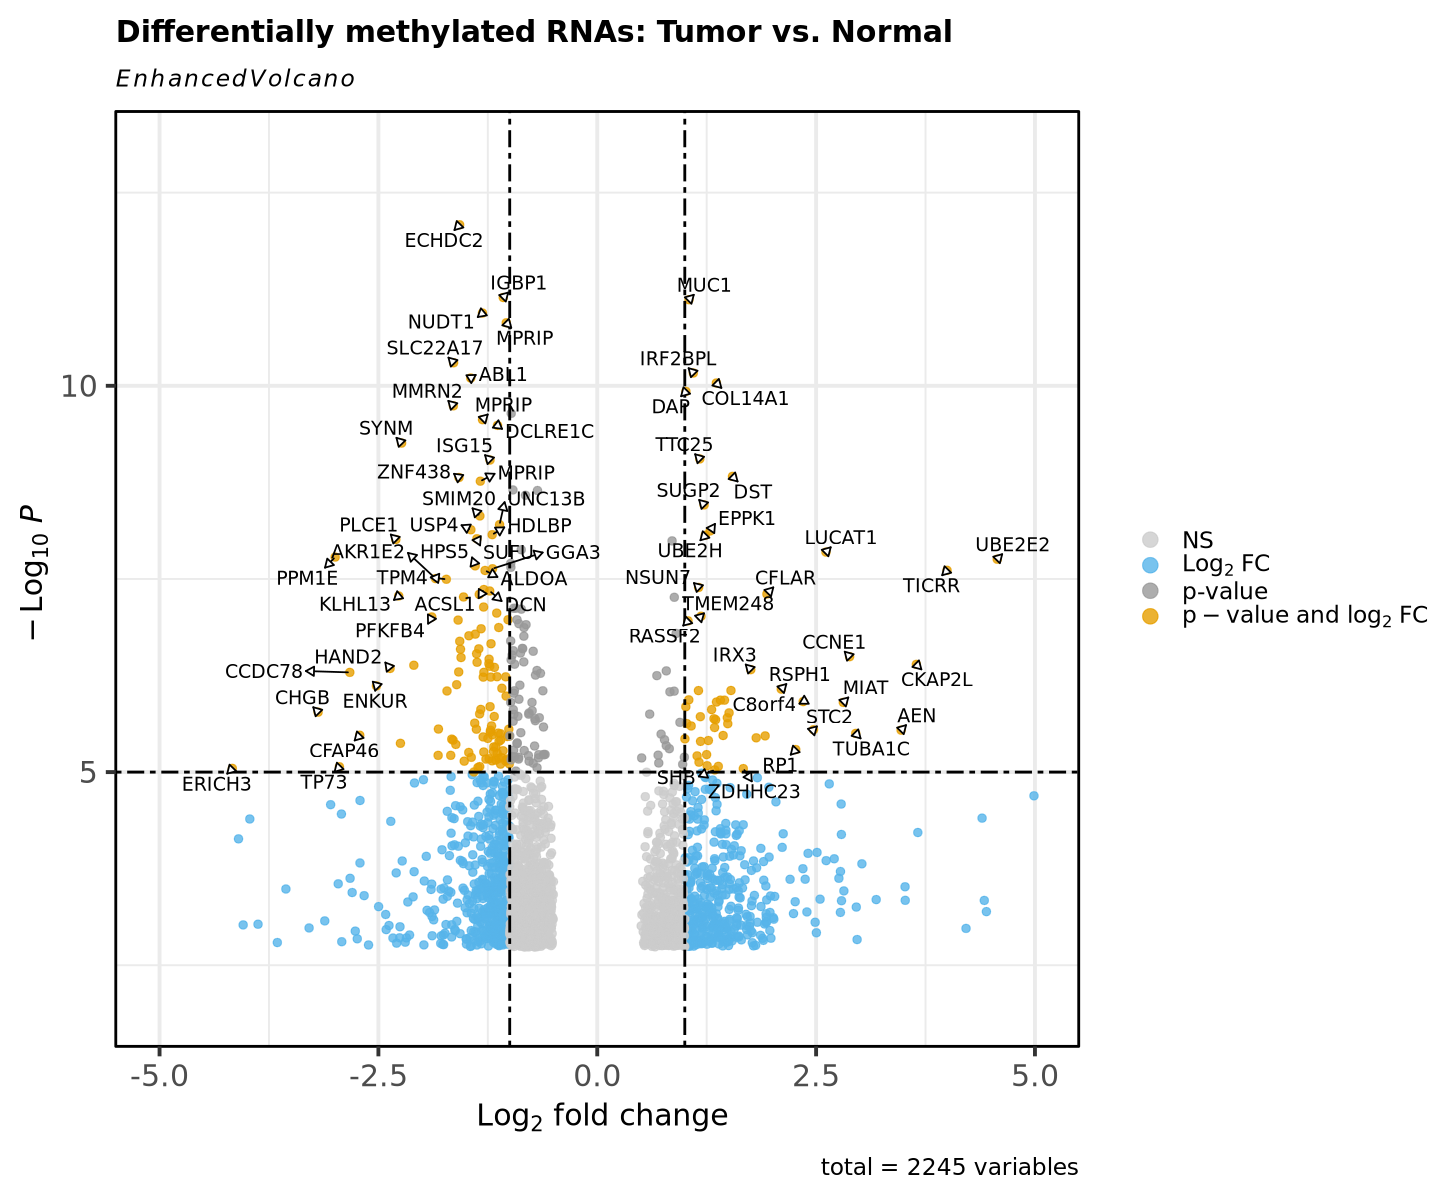

In [5]:
library("EnhancedVolcano")
options(repr.plot.width=12, repr.plot.height=10)
EnhancedVolcano(Diff_peaks_cov,
                title = "Differentially methylated RNAs: Tumor vs. Normal",
                lab = Diff_peaks_cov$name,
                x = 'logFC',
                y = 'p_value',
                xlim=c(-5,5),
                ylim=c(2,13),
                xlab = bquote(~Log[2]~ 'fold change'),
                cutoffLineType = 'twodash',
                cutoffLineWidth = 0.8,
                pointSize = 2,
                col = c('#cccccc', '#56B4E9', '#999999', '#E69F00'),
                colAlpha = 4/5,
                labSize = 4,
                legendPosition = 'right',
                legendLabSize = 14,
                legendIconSize = 4.0,
                drawConnectors = TRUE,
                widthConnectors = 0.5,
                colConnectors = 'black',
                border = "full")

### 2.2 Meta-Gene plot
A **meta-gene plot** is a visualization technique used in genomics to summarize read coverage or signal intensity across defined regions of interest, typically around gene bodies or specific genomic features, such as transcription start sites or methylation sites. In MeRIP-seq data analysis, a meta-gene plot helps illustrate the distribution of RNA methylation (like m6A) along genes, providing insights into where methylation commonly occurs, such as in the 5’ UTR, CDS, or 3’ UTR regions. This is helpful in MeRIP-seq studies because it allows researchers to observe patterns of methylation enrichment across genes, which can inform on potential regulatory roles of RNA modifications in gene expression. By comparing meta-gene plots across conditions, researchers can also identify shifts in methylation patterns, shedding light on condition-specific or disease-related changes in RNA methylation.

#### Step 1. Download GTF annotation file
For the organism being analyzed, user need to provide an annotation file in gtf format to define the genomic coordinate of gene features. A good source to download those supporting files are <a href="https://support.illumina.com/sequencing/sequencing_software/igenome.html">iGenome</a>. Alternatively, the <a href="https://www.gencodegenes.org/">GENCODE</a> is also a good source for annotation if you are interested in human and mouse genome. In our example, we use the human annotated genome downloaded from GENCODE.

In [6]:
system("wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_46/gencode.v46.basic.annotation.gtf.gz")
system("gzip -d gencode.v46.basic.annotation.gtf.gz")

#### Step 2. Generate meta-gene plot <mark style="background-color:AntiqueWhite;">(⏰ ~5 minites)</mark>
The <code>plotMetaGene</code> function in <code>MeRIPtools</code> visualizes the distribution of methylated RNA peaks across defined genomic regions, such as gene bodies, in MeRIP-seq data. It is used to examine differentially methylated peaks across conditions by plotting read density along key regions, like 5’ or 3’ UTRs. The function can display methylation patterns for both mRNA and lncRNA transcripts, enabling comparisons between them. This distinction is useful as mRNA methylation often influences translation and stability, while lncRNA methylation may affect structure and molecular interactions.

<img src="images/3-metaGeneplot.png" width="600" />

**Key Explanations**:
- X-Axis: Represents regions of the gene (e.g., 5’ UTR, CDS, 3’ UTR).
- Y-Axis: Reflects methylation intensity.
- Interpretation: Patterns can highlight methylation hotspots.

In [ ]:
library("MeRIPtools")
library(ggsci)
options(repr.plot.width=14, repr.plot.height=6)
plotMetaGene(Diff_peaks_cov,"gencode.v46.basic.annotation.gtf")

Loading required package: GenomicFeatures

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:data.table’:

    first, second


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, u

[1] "Converting BED12 to GRangesList"
[1] "It may take a few minutes"


Warning message in call_fun_in_txdbmaker("makeTxDbFromGFF", ...):
“makeTxDbFromGFF() has moved to the txdbmaker package. Please call
  txdbmaker::makeTxDbFromGFF() to get rid of this warning.”
Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”
OK



## <b>3. Functional enrichment analysis</b>
There are two major types of enrichment analysis:
1. **Over Representation Analysis (ORA)** (Boyle et al. 2004) is a widely used approach to determine whether known biological functions or processes are over-represented (= enriched) in an experimentally-derived gene list, e.g. a list of differentially expressed genes (DEGs). This approach will find genes where the difference is large and will fail where the difference is small, but evidenced in coordinated way in a set of related genes.
2. **Gene Set Enrichment Analysis (GSEA)** (Subramanian et al. 2005) aggregates the per gene statistics across genes within a gene set, therefore making it possible to detect situations where all genes in a predefined set change in a small but coordinated way. This is important since it is likely that many relevant phenotypic differences are manifested by small but consistent changes in a set of genes. Genes are ranked based on their phenotypes. Given apriori defined set of gene S (e.g., genes sharing the same DO category), the goal of GSEA is to determine whether the members of S are randomly distributed throughout the ranked gene list (L) or primarily found at the top or bottom.

Here, we use **ORA** to showcase the functional enrichment analysis. To begin with, load required packages and rename the genes:

In [ ]:
library(clusterProfiler)
library(org.Hs.eg.db)
eg_diffPeak_cov <- bitr(unique(Diff_peaks_cov$name), fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")

### 3.1 GO enrichment analysis 
Gene Ontology (GO) defines concepts/classes used to describe gene function, and relationships between these concepts. It classifies functions along three aspects:
- MF (Molecular Function): molecular activities of gene products
- CC (Cellular Component): where gene products are active
- BP (Biological Process): pathways and larger processes made up of the activities of multiple gene products

GO terms are organized in a directed acyclic graph, where edges between terms represent parent-child relationship.



In [ ]:
library(clusterProfiler)
library(org.Hs.eg.db)
eg_diffPeak_cov <- bitr(unique(Diff_peaks_cov$name), fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")
ego_diffPeak_cov <- enrichGO(gene  = eg_diffPeak_cov$ENTREZID,
                #universe      = bitr(rownames(RADAR@geneSum), fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID,
                OrgDb         = org.Hs.eg.db,
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05,
        readable      = TRUE)
head(ego_diffPeak_cov)

In [ ]:
library(enrichplot)
options(repr.plot.width=14, repr.plot.height=6)
barplot(ego_diffPeak_cov, showCategory=15) + dotplot(ego_diffPeak_cov, showCategory=15)

**Enrichment map** organizes enriched terms into a network with edges connecting overlapping gene sets. In this way, mutually overlapping gene sets are tend to cluster together, making it easy to identify functional module.

The <code>emapplot</code> function supports results obtained from hypergeometric test and gene set enrichment analysis. The cex_category parameter can be used to resize nodes

In [ ]:
ego_diffPeak_cov <- pairwise_termsim(ego_diffPeak_cov)
emapplot(ego_diffPeak_cov,showCategory = 25)+theme(legend.text = element_text(face = "bold"),legend.title = element_text(face = "bold") )

### 3.2 KEGG enrichment analysis
KEGG (Kyoto Encyclopedia of Genes and Genomes) is a collection of manually drawn pathway maps representing molecular interaction and reaction networks. These pathways cover a wide range of biochemical processes that can be divided into 7 broad categories:
* Metabolism
* Genetic information processing
* Environmental information processing
* Cellular processes
* Organismal systems
* Human diseases
* Drug development.

In [ ]:
# KEGG pathway analysis
KEGG_diffPeak_cov <- enrichKEGG(eg_diffPeak_cov$ENTREZID,organism = "hsa",pAdjustMethod = "none", pvalueCutoff = 0.05,minGSSize = 3)
head(KEGG_diffPeak_cov)

# bar and dot plots
barplot(KEGG_diffPeak_cov, showCategory=15) + dotplot(KEGG_diffPeak_cov, showCategory=15)

# enrichment map
KEGG_diffPeak_cov <- pairwise_termsim(KEGG_diffPeak_cov)
emapplot(KEGG_diffPeak_cov,showCategory = 25)+theme(legend.text = element_text(face = "bold"),legend.title = element_text(face = "bold") )

## <b>4. Integration of RNA methylation and gene expression</b>

### 4.1 use Input samples to get the gene expression profile

In [ ]:
# copy the data from s3 bucket to Tutorial_3 directory
system("aws s3 cp s3://ovarian-cancer-example-fastqs/submodule3/sample_info.txt .")

# load Sample information
samples <- data.frame(fread("sample_info.txt"),row.names=2)
samples <- subset(samples, Sample_description=="total RNA") # the other description is: m6A enriched RNA
samples$group <- factor(ifelse(grepl("normal",samples$Group), "normal", "tumor"))
samples

In [ ]:
# load input gene count matrix
read_counts <- fread("GSE119168_raw_counts_GRCh38.p13_NCBI.tsv.gz")
read_counts <- data.frame(read_counts,row.names=1)
dim(read_counts)

# Keep the input samples only
cts <- read_counts[,rownames(samples)]
dim(cts)

### 4.2 DESeq2 differential gene expression analysis

In [ ]:
library(DESeq2)

#Create the DEseq2DataSet object
dds <- DESeqDataSetFromMatrix(countData = cts, colData = samples, design= ~ Age + group)

# Perform pre-filtering of the data
dds <- dds[rowSums(counts(dds)) > 10, ]

# Run pipeline for differential expression steps
dds <- DESeq(dds)
resultsNames(dds) # lists the coefficients

# show results of contrast comparisons
res <- results(dds, contrast = c("group", "tumor", "normal"))
summary(res)

**Volcano plot** of the differential expressed genes

In [ ]:
# annotate GENEID to gene symbol
library("clusterProfiler")
library("org.Hs.eg.db")
res_symbol <- bitr(rownames(res), fromType="ENTREZID", toType="SYMBOL", OrgDb="org.Hs.eg.db")
res_symbol <- data.frame(res_symbol,row.names=1)

# visualization of the Deseq2 restuls
library("EnhancedVolcano")

options(repr.plot.width=12, repr.plot.height=10)
EnhancedVolcano(res,
                lab = res_symbol[rownames(res),],
                title = 'Gene expression: tumor vs. normal',
                x = 'log2FoldChange',
                y = 'padj',
                ylim=c(0,7),
                pCutoff = 0.05,
                xlab = bquote(~Log[2]~ 'fold change'),
                cutoffLineType = 'twodash',
                cutoffLineWidth = 0.8,
                pointSize = 2,
                col = c('#cccccc', '#56B4E9', '#999999', '#E69F00'),
                colAlpha = 4/5,
                labSize = 4,
                legendPosition = 'right',
                legendLabSize = 14,
                legendIconSize = 4.0,
                drawConnectors = TRUE,
                widthConnectors = 0.5,
                colConnectors = 'black',
                border = "full")

### 4.3 Integrate RNA methylation and expression Data

In [ ]:
# gene expression results
res <- results(dds, contrast = c("group", "tumor", "normal"))
de <- as.data.frame(res)
de$gene <- res_symbol[rownames(de),]
de <- de[!is.na(de$gene) & de$pvalue<0.05 & abs(de$log2FoldChange)>1,]

# RNA methylation results 
dmr <- Diff_peaks_cov[,c("name","logFC","p_value")]
dim(dmr)

# join two results 
combined <- merge(x=de, y=dmr, by.x="gene",by.y="name")
dim(combined)
head(combined)

In [ ]:
# integration volcano plot
library(ggplot2)
fc_cutoff <- 1.5
df <- combined
df$class[df$log2FoldChange >= fc_cutoff & df$logFC >= fc_cutoff]  <- "A"
df$class[df$log2FoldChange >= fc_cutoff & df$logFC <= -fc_cutoff]  <- "B"
df$class[df$log2FoldChange <= -fc_cutoff & df$logFC >= fc_cutoff]  <- "C"
df$class[df$log2FoldChange <= -fc_cutoff & df$logFC <= -fc_cutoff]  <- "D"
table(df$class)
df[is.na(df$class),"class"] <-  "E"
df$label <- ifelse(df$class=="E", "", df$gene)

cols <- c("#CC79A7", "#0072B2", "#D55E00", "#E69F00", "#999999")
ggplot(df, aes(x=log2FoldChange, y=logFC, color=class)) + 
    geom_point(aes(size=-log10(padj)),shape = 16,  show.legend = FALSE, alpha = .7) + #size = 2.5,
    scale_color_manual(values = cols) + 
    geom_vline(xintercept = c(-fc_cutoff, fc_cutoff),linetype="dashed") + 
    geom_hline(yintercept = c(-fc_cutoff, fc_cutoff),linetype="dashed") +
    geom_text_repel(aes(label=label)) +
    labs(x= "Log2FC (gene expression)", y="Log2FC (RNA methylation)",title="Tumor vs. Normal") +
    theme(legend.position="none",
          panel.background=element_rect(fill="grey95"),
          panel.border = element_rect(color = "black",fill = NA,linewidth = 2),
          plot.title = element_text(size=20,hjust=0.5),
          axis.text = element_text(size=15),
          axis.title = element_text(size=20)) 

## Conclusion
In this module, we covered:
1. Volcano Plots: Simplified visualization of differential changes.
2. Meta-Gene Plots: Insights into methylation distributions across gene features.
3. Functional Enrichment Analysis: Biological context for methylated genes.
4. Integration: Linking methylation changes to expression differences for comprehensive insights.

By integrating these approaches, researchers can uncover the functional relevance of RNA methylation in various biological conditions.

## Next steps (not included in this module) ...
1. Review results from functional enrichment and integration analyses.
2. Apply the learned workflows to your dataset.
3. Validate findings through experimental methods.

## <b>Quiz</b>  <img src="images/quiz-time.png" width="150" align="middle"/>

In [ ]:
packages <- c("EnhancedVolcano", "clusterProfiler", "org.Hs.eg.db")
package_versions <- installed.packages()[packages, "Version"]
# Print package names and their versions
print(data.frame(Version = package_versions))

In [ ]:
IRdisplay::display_html('<iframe src="questions/Q3.html" width=100% height=450></iframe>')

In [ ]:
IRdisplay::display_html('<iframe src="questions/F3.html" width=100% height=400></iframe>')

## Clean up
A reminder to shutdown VM and delete any relevant resources. <br><br>